# Homework 10 - Group 14

The following code takes an English translation of the bible. It tokenizes the words and filters out punctuation and stop words (commonly occuring words that don't add much meaning). The tokens are used to train a skipgram model that uses negative sampling (with randomly chosen words) for training. The training progress is shown through a graph and tables with example words and their assigned 5 nearest neighbors during different states of the training.

# 2.1 The Dataset
The text file of the bible is taken from a connected drive and as an example to validate that it worked as intended, the first 200 characters are printed.

In [ ]:
import os
from google.colab import drive

#load data by mounting to drive

drive.mount("/content/drive")
os.chdir("drive/MyDrive")

# read txt file
f = open("bible.txt", "r")
bible = f.read()

print("Total Characters: ", len(bible))
print("First 200 Characters:\n" + bible[:200])

Mounted at /content/drive
Total Characters:  4332496
First 200 Characters:
The First Book of Moses:  Called Genesis


1:1 In the beginning God created the heaven and the earth.

1:2 And the earth was without form, and void; and darkness was upon
the face of the deep. And the


# 2.2 Word Embeddings
A tokenizer is created that first learns a vocabulary from the bible list and then translates the bible list into a list of corresponding tokens. The tokenizer already filters out punctuation. Stop-words were taken out to make the data more meaningful. To reduce the data set further, subsampling was applied to filter out some of the most common words. Finally, context-target wordpairs are created. To utilize negative subsampling during training, for each positive sample that is created, the are five negative samples created. The pairs are matched with a corresponding label - 1 for true and 0 for false.


In [ ]:
import tensorflow as tf
import numpy as np

vocabulary_size = 10000

# Tokenize the text
# automatically converts to lowercase and removes new lines and special characters
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocabulary_size) 
tokenizer.fit_on_texts([bible])
tokens = tokenizer.texts_to_sequences([bible])[0]

n_tokens = len(tokens)


# store relative frequencies of tokens at respective index (e.g. token_frequencies[1] = frequency of token with integer=1)
# for subsampling and negative sampling
token_frequencies = [0]
for word, token in tokenizer.word_index.items():
    # get number of occurences for each token
    frequency = tokenizer.word_counts.get(word)
    token_frequencies.append(frequency)
# divide by sum of all occurences
token_frequencies = token_frequencies / np.sum(token_frequencies)


print("Total number of Tokens:", n_tokens)
print("Vocabulary size:", vocabulary_size)
print("First 10 Token integers:", tokens[:10])

Total number of Tokens: 426142
Vocabulary size: 9000
First 10 Token integers: [1, 249, 360, 3, 105, 192, 6020, 67, 67, 5]


In [ ]:
# removing stop words to reduce dataset and make it more expressive
# (commonly occuring words that don't carry much meaning)

# translate list of stop words into tokens
stop_words = '''"0o", "0s", "3a", "3b", "3d", "6b", "6o", "a", "a1", "a2", "a3", "a4", "ab", "able", "about", "above", "abst", "ac", "accordance", "according", "accordingly", "across", "act", "actually", "ad", "added", "adj", "ae", "af", "affected", "affecting", "affects", "after", "afterwards", "ag", "again", "against", "ah", "ain", "ain't", "aj", "al", "all", "allow", "allows", "almost", "alone", "along", "already", "also", "although", "always", "am", "among", "amongst", "amoungst", "amount", "an", "and", "announce", "another", "any", "anybody", "anyhow", "anymore", "anyone", "anything", "anyway", "anyways", "anywhere", "ao", "ap", "apart", "apparently", "appear", "appreciate", "appropriate", "approximately", "ar", "are", "aren", "arent", "aren't", "arise", "around", "as", "a's", "aside", "ask", "asking", "associated", "at", "au", "auth", "av", "available", "aw", "away", "awfully", "ax", "ay", "az", "b", "b1", "b2", "b3", "ba", "back", "bc", "bd", "be", "became", "because", "become", "becomes", "becoming", "been", "before", "beforehand", "begin", "beginning", "beginnings", "begins", "behind", "being", "believe", "below", "beside", "besides", "best", "better", "between", "beyond", "bi", "bill", "biol", "bj", "bk", "bl", "bn", "both", "bottom", "bp", "br", "brief", "briefly", "bs", "bt", "bu", "but", "bx", "by", "c", "c1", "c2", "c3", "ca", "call", "came", "can", "cannot", "cant", "can't", "cause", "causes", "cc", "cd", "ce", "certain", "certainly", "cf", "cg", "ch", "changes", "ci", "cit", "cj", "cl", "clearly", "cm", "c'mon", "cn", "co", "com", "come", "comes", "con", "concerning", "consequently", "consider", "considering", "contain", "containing", "contains", "corresponding", "could", "couldn", "couldnt", "couldn't", "course", "cp", "cq", "cr", "cry", "cs", "c's", "ct", "cu", "currently", "cv", "cx", "cy", "cz", "d", "d2", "da", "date", "dc", "dd", "de", "definitely", "describe", "described", "despite", "detail", "df", "di", "did", "didn", "didn't", "different", "dj", "dk", "dl", "do", "does", "doesn", "doesn't", "doing", "don", "done", "don't", "down", "downwards", "dp", "dr", "ds", "dt", "du", "due", "during", "dx", "dy", "e", "e2", "e3", "ea", "each", "ec", "ed", "edu", "ee", "ef", "effect", "eg", "ei", "eight", "eighty", "either", "ej", "el", "eleven", "else", "elsewhere", "em", "empty", "en", "end", "ending", "enough", "entirely", "eo", "ep", "eq", "er", "es", "especially", "est", "et", "et-al", "etc", "eu", "ev", "even", "ever", "every", "everybody", "everyone", "everything", "everywhere", "ex", "exactly", "example", "except", "ey", "f", "f2", "fa", "far", "fc", "few", "ff", "fi", "fifteen", "fifth", "fify", "fill", "find", "fire", "first", "five", "fix", "fj", "fl", "fn", "fo", "followed", "following", "follows", "for", "former", "formerly", "forth", "forty", "found", "four", "fr", "from", "front", "fs", "ft", "fu", "full", "further", "furthermore", "fy", "g", "ga", "gave", "ge", "get", "gets", "getting", "gi", "give", "given", "gives", "giving", "gj", "gl", "go", "goes", "going", "gone", "got", "gotten", "gr", "greetings", "gs", "gy", "h", "h2", "h3", "had", "hadn", "hadn't", "happens", "hardly", "has", "hasn", "hasnt", "hasn't", "have", "haven", "haven't", "having", "he", "hed", "he'd", "he'll", "hello", "help", "hence", "her", "here", "hereafter", "hereby", "herein", "heres", "here's", "hereupon", "hers", "herself", "hes", "he's", "hh", "hi", "hid", "him", "himself", "his", "hither", "hj", "ho", "home", "hopefully", "how", "howbeit", "however", "how's", "hr", "hs", "http", "hu", "hundred", "hy", "i", "i2", "i3", "i4", "i6", "i7", "i8", "ia", "ib", "ibid", "ic", "id", "i'd", "ie", "if", "ig", "ignored", "ih", "ii", "ij", "il", "i'll", "im", "i'm", "immediate", "immediately", "importance", "important", "in", "inasmuch", "inc", "indeed", "index", "indicate", "indicated", "indicates", "information", "inner", "insofar", "instead", "interest", "into", "invention", "inward", "io", "ip", "iq", "ir", "is", "isn", "isn't", "it", "itd", "it'd", "it'll", "its", "it's", "itself", "iv", "i've", "ix", "iy", "iz", "j", "jj", "jr", "js", "jt", "ju", "just", "k", "ke", "keep", "keeps", "kept", "kg", "kj", "km", "know", "known", "knows", "ko", "l", "l2", "la", "largely", "last", "lately", "later", "latter", "latterly", "lb", "lc", "le", "least", "les", "less", "lest", "let", "lets", "let's", "lf", "like", "liked", "likely", "line", "little", "lj", "ll", "ll", "ln", "lo", "look", "looking", "looks", "los", "lr", "ls", "lt", "ltd", "m", "m2", "ma", "made", "mainly", "make", "makes", "many", "may", "maybe", "me", "mean", "means", "meantime", "meanwhile", "merely", "mg", "might", "mightn", "mightn't", "mill", "million", "mine", "miss", "ml", "mn", "mo", "more", "moreover", "most", "mostly", "move", "mr", "mrs", "ms", "mt", "mu", "much", "mug", "must", "mustn", "mustn't", "my", "myself", "n", "n2", "na", "name", "namely", "nay", "nc", "nd", "ne", "near", "nearly", "necessarily", "necessary", "need", "needn", "needn't", "needs", "neither", "never", "nevertheless", "new", "next", "ng", "ni", "nine", "ninety", "nj", "nl", "nn", "no", "nobody", "non", "none", "nonetheless", "noone", "nor", "normally", "nos", "not", "noted", "nothing", "novel", "now", "nowhere", "nr", "ns", "nt", "ny", "o", "oa", "ob", "obtain", "obtained", "obviously", "oc", "od", "of", "off", "often", "og", "oh", "oi", "oj", "ok", "okay", "ol", "old", "om", "omitted", "on", "once", "one", "ones", "only", "onto", "oo", "op", "oq", "or", "ord", "os", "ot", "other", "others", "otherwise", "ou", "ought", "our", "ours", "ourselves", "out", "outside", "over", "overall", "ow", "owing", "own", "ox", "oz", "p", "p1", "p2", "p3", "page", "pagecount", "pages", "par", "part", "particular", "particularly", "pas", "past", "pc", "pd", "pe", "per", "perhaps", "pf", "ph", "pi", "pj", "pk", "pl", "placed", "please", "plus", "pm", "pn", "po", "poorly", "possible", "possibly", "potentially", "pp", "pq", "pr", "predominantly", "present", "presumably", "previously", "primarily", "probably", "promptly", "proud", "provides", "ps", "pt", "pu", "put", "py", "q", "qj", "qu", "que", "quickly", "quite", "qv", "r", "r2", "ra", "ran", "rather", "rc", "rd", "re", "readily", "really", "reasonably", "recent", "recently", "ref", "refs", "regarding", "regardless", "regards", "related", "relatively", "research", "research-articl", "respectively", "resulted", "resulting", "results", "rf", "rh", "ri", "right", "rj", "rl", "rm", "rn", "ro", "rq", "rr", "rs", "rt", "ru", "run", "rv", "ry", "s", "s2", "sa", "said", "same", "saw", "say", "saying", "says", "sc", "sd", "se", "sec", "second", "secondly", "section", "see", "seeing", "seem", "seemed", "seeming", "seems", "seen", "self", "selves", "sensible", "sent", "serious", "seriously", "seven", "several", "sf", "shall", "shan", "shan't", "she", "shed", "she'd", "she'll", "shes", "she's", "should", "shouldn", "shouldn't", "should've", "show", "showed", "shown", "showns", "shows", "si", "side", "significant", "significantly", "similar", "similarly", "since", "sincere", "six", "sixty", "sj", "sl", "slightly", "sm", "sn", "so", "some", "somebody", "somehow", "someone", "somethan", "something", "sometime", "sometimes", "somewhat", "somewhere", "soon", "sorry", "sp", "specifically", "specified", "specify", "specifying", "sq", "sr", "ss", "st", "still", "stop", "strongly", "sub", "substantially", "successfully", "such", "sufficiently", "suggest", "sup", "sure", "sy", "system", "sz", "t", "t1", "t2", "t3", "take", "taken", "taking", "tb", "tc", "td", "te", "tell", "ten", "tends", "tf", "th", "than", "thank", "thanks", "thanx", "that", "that'll", "thats", "that's", "that've", "the", "their", "theirs", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "thered", "therefore", "therein", "there'll", "thereof", "therere", "theres", "there's", "thereto", "thereupon", "there've", "these", "they", "theyd", "they'd", "they'll", "theyre", "they're", "they've", "thickv", "thin", "think", "third", "this", "thorough", "thoroughly", "those", "thou", "though", "thoughh", "thousand", "three", "throug", "through", "throughout", "thru", "thus", "ti", "til", "tip", "tj", "tl", "tm", "tn", "to", "together", "too", "took", "top", "toward", "towards", "tp", "tq", "tr", "tried", "tries", "truly", "try", "trying", "ts", "t's", "tt", "tv", "twelve", "twenty", "twice", "two", "tx", "u", "u201d", "ue", "ui", "uj", "uk", "um", "un", "under", "unfortunately", "unless", "unlike", "unlikely", "until", "unto", "uo", "up", "upon", "ups", "ur", "us", "use", "used", "useful", "usefully", "usefulness", "uses", "using", "usually", "ut", "v", "va", "value", "various", "vd", "ve", "ve", "very", "via", "viz", "vj", "vo", "vol", "vols", "volumtype", "vq", "vs", "vt", "vu", "w", "wa", "want", "wants", "was", "wasn", "wasnt", "wasn't", "way", "we", "wed", "we'd", "welcome", "well", "we'll", "well-b", "went", "were", "we're", "weren", "werent", "weren't", "we've", "what", "whatever", "what'll", "whats", "what's", "when", "whence", "whenever", "when's", "where", "whereafter", "whereas", "whereby", "wherein", "wheres", "where's", "whereupon", "wherever", "whether", "which", "while", "whim", "whither", "who", "whod", "whoever", "whole", "who'll", "whom", "whomever", "whos", "who's", "whose", "why", "why's", "wi", "widely", "will", "willing", "wish", "with", "within", "without", "wo", "won", "wonder", "wont", "won't", "words", "world", "would", "wouldn", "wouldnt", "wouldn't", "www", "x", "x1", "x2", "x3", "xf", "xi", "xj", "xk", "xl", "xn", "xo", "xs", "xt", "xv", "xx", "y", "y2", "yes", "yet", "yj", "yl", "you", "youd", "you'd", "you'll", "your", "youre", "you're", "yours", "yourself", "yourselves", "you've", "yr", "ys", "yt", "z", "zero", "zi", "zz"'''
stop = ''.join(letter for letter in str(stop_words) if letter not in '",')
stop_tokens = tokenizer.texts_to_sequences([stop_words])[0]

# filter bible tokens for stop words
tokens = [token for token in tokens if token not in stop_tokens]
n_tokens = len(tokens)

print("Total number of Tokens:", n_tokens)
print("First 10 Token integers after filtering:", tokens[:10])

Total number of Tokens: 169595
First 10 Token integers after filtering: [360, 105, 192, 6020, 67, 67, 29, 1980, 277, 163]


In [ ]:
# compute probability with which a token is kept in the dataset
def token_probability(token, token_frequencies, scale=0.001):
    """Calculates the probability that a token is removed from the dataset based on its frequency in the text.

    Args:
        token(int): number that is assigned to represent the word
        token_frequencies(list): list with the relative frequencies of all tokens at respective index
        scale(float): constant, that controls how likely it is that a word is kept

    Returns:
        Probability that input token is kept in vocabulary

    """
    # calculate relative frequency of token occuring in the text
    token_frequency = token_frequencies[token]
    # probability formula
    probability = (np.sqrt(token_frequency / scale) + 1) * (scale / token_frequency)

    return probability


# subsampling: remove frequent tokens by certain probability
s = 0.001
tokens = [token for token in tokens if np.random.uniform(0, 1) < token_probability(token, token_frequencies, scale=s)]
n_tokens = len(tokens)

print("Total number of Tokens:", n_tokens)
print("First 10 Token integers after filtering:", tokens[:10])

Total number of Tokens: 162761
First 10 Token integers after filtering: [360, 105, 192, 6020, 67, 67, 29, 1980, 277, 163]


In [ ]:
# Generate target-context pairs
# performs negative sampling 
# for each positive pair sample 3 negative pairs
pairs, labels = tf.keras.preprocessing.sequence.skipgrams(sequence=tokens, 
                                                          vocabulary_size=vocabulary_size, 
                                                          window_size=2,
                                                          negative_samples=3 # ratio of negative compared to positive samples
                                                          )

print("Total number of Pairs:", len(pairs))
print("Example input-target pair:", pairs[0], "with Label:", labels[0])

Total number of Pairs: 2604152
Example input-target pair: [62, 7458] with Label: 0


# 2.3 The Model
A SkipGram NN-Model is implemented with an embedding layer, a flatten layer and a dense output layer. The model predicts whether the presented pair is true or false.

In [ ]:
# SkipGram NN model
class SkipGram(tf.keras.Model):
    """Subclass of tf.keras.Model that is trained to determine if a context, target token pair is positive or negative.

    Args:
        tf.keras.Model

    """
    def __init__(self, embedding_units=64):
        """Initializes an embedding, a flatten and a dense layer for the model

        Args:
            embedding_units(int): size of the embedding

        """
        super().__init__()

        self.embedding_units = embedding_units
        regularizer = tf.keras.regularizers.L2() 

        # two main layers: embedding and dense output layer (+ in between flatten)
        self.embedding = tf.keras.layers.Embedding(input_dim=vocabulary_size,
                                                   output_dim=embedding_units,
                                                   input_length=2,
                                                   input_shape=(2,),
                                                   embeddings_regularizer=regularizer
                                                   )
        self.flatten = tf.keras.layers.Flatten()
        self.out = tf.keras.layers.Dense(units=1, activation='sigmoid')


    @tf.function
    def call(self, x):
        """Passes input x through all the layers of the model.

        Args:
            self = this instance of the class
            x (tuple of ints): context, target token pair

        Returns:
            prediction of the model 

        """

        x = self.embedding(x)
        x = self.flatten(x)
        x = self.out(x)

        return x

# 2.4 Training
A tracker for the nearest neighbors is implemented. The accuracy and loss for training and testing data are visualized and tables are printed which show the training process for 8 tracking words. Since most training seems to happen in the first epoch, there are tables printed after each 5000 batches.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# class for function called at end of each epoch
# tracking the k-nearest words of tracking words during training
class TrackingNeighbors(tf.keras.callbacks.Callback):
    """The class provides functions to track the k-nearest neighbors of a token. Is a subclass of tf.keras.callbacks.Callback.

    Args:
         tf.keras.callbacks.Callback

    """

    def __init__(self, model, tracking_words, tokenizer, k=5):
        """Creates a dictionary for each word that is to be tracked.

        Args:
            self: this instance of the class
            model(SkipGram): SkipGram Model that is being trained
            tracking_words(list of strings): words to keep track of during training
            tokenizer(tf.keras.preprocessing.text.Tokenizer): object that creates tokens out of strings
            k(int): number of neighbors to return for each tracked word

        Returns:
            prediction of the model 

        """
        super().__init__()
        
        self.model = model
        self.k = k
        self.tracking_words = tracking_words

        # dictionaries where neighbors of all tracking words get appended
        # one for every epoch
        self.neighbors_dict_epochs = {}
        for word in tracking_words:
            self.neighbors_dict_epochs[word] = [] # keys = tracking words
        
        # and one for intermediate samples during the first epoch
        self.neighbors_dict_batches = {}
        for word in tracking_words:
            self.neighbors_dict_batches[word] = []

        # for sampling batches of the first epoch
        self.batch_counter = 0
        self.epoch1 = True
        

    # called at end of each batch during training
    def on_train_batch_end(self, batch, logs=None):
        """Counts up a timer during the first epoch and calls tracking_neighbors after each 5000 batches

        Args:
            self: this instance of the class
            batch(bool): indicates if we are at the end of a batch
            logs(None)

        """
        if self.epoch1:
            if self.batch_counter%7000 == 0:
                self.tracking_neighbors(self.model, batch=True)
            self.batch_counter += 1
        

    # called at end of each epoch
    def on_epoch_end(self, epoch, logs=None):
        """After each epoch calls tracking_neighbors

        Args:
            self: this instance of the class
            epoch(int): current epoch
            logs(None)

        """
        self.tracking_neighbors(self.model, batch=False)
        self.epoch1 = False # so that only in first epoch intermediate batches are sampled


    def cosine_similarities(self, token, embeddings, embedding_units):
        """Calculates the cosine similarity of a word embedding to the other embeddings and returns the k nearest tokens

        Args:
            self: this instance of the class
            token(int): an integer representing one word of the vocabulary 
            embeddings(nested list): list of all embeddings 
            embedding_units(list)
        
        Returns:
            k nearest tokens

        """

        # get embedding of specific token
        word_embedding = embeddings[token].reshape(1,embedding_units)

        # compute cosine similarity
        cosine_similarities = cosine_similarity(embeddings, word_embedding).tolist()

        # get the index of the k nearest embeddings (without the tracked token itself)
        # index = corresponding token (as integer not word)
        k_nearest_tokens = sorted(range(len(cosine_similarities)), key = lambda sub: cosine_similarities[sub])[-(self.k+1):-1]
      
        return k_nearest_tokens


    def tracking_neighbors(self, model, batch):
        """Calculates the nearest neighbors of each token in the list of words to track.

        Args:
            self: this instance of the class
            model(SkipGram): SkipGram Model that is being trained
            batch(bool): indicates if we are at the end of a batch

        """

        # retrieve the embeddings
        embeddings = self.model.embedding.get_weights()[0]
        embedding_units = self.model.embedding_units

        # for token get nearest neighbors and append to dictionary under right key
        for i, word in enumerate(self.tracking_words):

            # translate word into token
            token = tokenizer.word_index.get(word)
            # get 'neighbor' tokens
            nearest_tokens = self.cosine_similarities(token, embeddings, embedding_units)
            # translate tokens back into words and reverse the list (so that closest is at first)
            nearest_neighbors = list(reversed(tokenizer.sequences_to_texts([nearest_tokens])[0].split()))
            
            # update dictionary
            if batch:
                self.neighbors_dict_batches[word].append(nearest_neighbors)
            else:
                self.neighbors_dict_epochs[word].append(nearest_neighbors)
          
        


In [ ]:
import matplotlib.pyplot as plt

# plotting function for performance metrics
def plothist(hist):
    print("\n============== Performance of Model ================")

    line1, = plt.plot(hist.history['loss'])
    line2, = plt.plot(hist.history['accuracy'])
    line3, = plt.plot(history.history['val_loss'])
    line4, = plt.plot(history.history['val_accuracy']) 
    plt.title('Model Performance')
    plt.ylabel('Loss/Accuracy')
    plt.xlabel('Training steps')
    plt.legend((line1, line2, line3, line4),("train loss", "train accuracy", "val loss", "val accuracy"))
    plt.show()

In [ ]:
from prettytable import PrettyTable

# plotting function for neighbors of tracking words
def print_neighbors(tracking, tracking_words, epochs):
   
    batches_dict = tracking.neighbors_dict_batches
    epoches_dict = tracking.neighbors_dict_epochs

    print("\n=============== Nearest neighbors from samples during first epoch ===============")

    # print a table for each sampled batch
    for sample in range(len(batches_dict.get(tracking_words[0]))):
        print(f"Sample {sample}")
        
        # iterate through dictionary
        # print table with neighbor words of current epoch
        table = PrettyTable()
        columns = tracking_words
        for i, word in enumerate(tracking_words):
            table.add_column(columns[i], batches_dict.get(word)[sample])

        print(table)   

    print("\n=============== Nearest neighbors at end of each epoch ===============")

    # print a table for each sampled batch
    for epoch in range(1, epochs+1):
        print(f"Epoch {epoch}")
        
        # iterate through dictionary
        # print table with neighbor words of current epoch
        table = PrettyTable()
        columns = tracking_words
        for i, word in enumerate(tracking_words):
            table.add_column(columns[i], batches_dict.get(word)[epoch])

        print(table)   


Epoch 1/2


/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("Adam/gradients/PartitionedCall:1", shape=(None,), dtype=int64), values=Tensor("Adam/gradients/PartitionedCall:0", shape=(None, 100), dtype=float32), dense_shape=Tensor("Adam/gradients/PartitionedCall:2", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


    5/32552 [..............................] - ETA: 7:34 - loss: 7.3432 - accuracy: 0.4812    

32552/32552 [==============================] - 294s 9ms/step - loss: 0.4995 - accuracy: 0.8482 - val_loss: 0.4431 - val_accuracy: 0.8562
Epoch 2/2
32552/32552 [==============================] - 279s 9ms/step - loss: 0.4246 - accuracy: 0.8609 - val_loss: 0.4102 - val_accuracy: 0.8643

============== Performance of Model ================


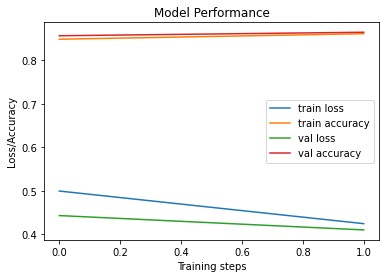


=============== Nearest neighbors from samples during first epoch ===============
Sample 0
+-----------+-----------+----------+------------+-------------+----------+--------------+-----------+
|    god    |    good   |  stone   |    hand    |     sin     |  father  |    mother    |   woman   |
+-----------+-----------+----------+------------+-------------+----------+--------------+-----------+
|  terraces |  blasting | watering | ramathlehi |    punon    |  beside  | unprofitable |    amal   |
|  helping  |  lionlike |  faults  |  zebadiah  |   uttered   |   foot   |   moabite    |   weaker  |
|  thahash  |    pole   |   out    |  repaired  |    groan    |  rigour  |   situate    |  borrowed |
|   desert  |  gershon  |  north   |   equal    |    cockle   | fighteth |     shot     | tirshatha |
| adversity | pasdammim | giddalti |  japhlet   | meronothite |  bewail  |   oppress    |  stilled  |
+-----------+-----------+----------+------------+-------------+----------+--------------+---

In [ ]:
# model
model = SkipGram(embedding_units=100)
model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy']
              )

# words that ought to be tracked during training
tracking_words = ["god", "good", "stone", "hand", "sin", "father", "mother", "woman"]
# callback class with tracking function (called after each epoch)
tracking = TrackingNeighbors(model, tracking_words, tokenizer, k=5)

# index for splitting the data in training (80%) and validation set (20%)
split = int(len(pairs) * 4/5) 

# training
epochs = 5
history = model.fit(x=pairs[:split], 
                    y=labels[:split], 
                    batch_size=64, 
                    epochs=epochs,
                    validation_data=(pairs[split:], labels[split:]),
                    callbacks=[tracking]
                    )

# visualization
plothist(history)
print_neighbors(tracking, tracking_words, epochs)